# Предсказание оттока пользователей оператора связи

Условному оператору связи необходимо повысить удержание клиентов. Для достижения этой цели планируется создать модель машинного обучения для предсказания того, планирует ли клиент уходить или нет. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.

Данные состоят из файлов, полученных из разных источников:
- contract.csv — информация о договоре;
- personal.csv — персональные данные клиента;
- internet.csv — информация об интернет-услугах;
- phone.csv — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на **1 февраля 2020**.

Цель проекта:
    Реализовать модель машинного обучения для решения задачи бинарной классификации клиента оператора связи. Один клиент может принадлежать к одному из двух классов: продолжает пользоваться услугами оператора или уходит. Основной метрикой оценки модели является ROC-AUC, а accuracy - дополнительная метрика. Минимальное необходимое значение ROC-AUC для успешного выполнения проекта равно **0.85**.

Первичный план работы:
 1. Загрузка и краткий обзор данных
 2. Исследование распределения признаков в данных. Исследование аномальных значений и дисбаланса классов.
 3. Выбор необходимых для обучения модели признаков
 4. Encoding категориальных переменных и масштабирование. Формирование обучающей и тестовов выборок.
 5. Обучение различных модели машинного обучения и их сравнение
 6. Проверка лучшей модели на тестовой выборке.
 7. Финальный вывод по работе

## Исследовательский анализ данных

In [1]:
# !pip install phik

In [2]:
import os
import pandas as pd
import numpy as np
import phik
import seaborn as sns
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    RandomizedSearchCV,
    train_test_split,
    StratifiedKFold
)

In [3]:
DATA_EXTRACT_TIMESTAMP = pd.Timestamp(2020, 2, 1)
RANDOM_STATE = 231222
TEST_SIZE = 0.25

### Загрузка данных

In [4]:
server_pth = '/datasets/final_provider/'
pc_path = './data/'

if os.path.exists(server_pth):
    df_contract = pd.read_csv(server_pth + "contract.csv")
    df_personal = pd.read_csv(server_pth + "personal.csv")
    df_internet = pd.read_csv(server_pth + "internet.csv")
    df_phone = pd.read_csv(server_pth + "phone.csv")
elif os.path.exists(pc_path):
    df_contract = pd.read_csv(pc_path + "contract.csv")
    df_personal = pd.read_csv(pc_path + "personal.csv")
    df_internet = pd.read_csv(pc_path + "internet.csv")
    df_phone = pd.read_csv(pc_path + "phone.csv")
else:
    print('Datasets not found')

Данные загружены успешно, рассмотрим каждый датасет по отдельности

### Данные о договоре

In [5]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [6]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [7]:
df_contract['customerID'].duplicated().sum()

0

In [8]:
df_contract['EndDate'].value_counts(normalize=True)

No                     0.734630
2019-11-01 00:00:00    0.068863
2019-12-01 00:00:00    0.066165
2020-01-01 00:00:00    0.065313
2019-10-01 00:00:00    0.065029
Name: EndDate, dtype: float64

Как можно заметить, в датасете нет пропусков и дубликатов. Однако, некоторые столбцы имеют некорректный тип данных. Так, для столбцов `BeginDate` и `EndDate` это должен быть тип данных с датой, для `PaperlessBilling` это может быть boolean, а для `TotalCharges` - float.

Из всех признаков в наших датасетах для прогнозирования оттока клиентов больше всего подходит признак `EndDate`, который напрямую отражает, остался клиент в сервисе или нет. Однако, почти у 73% пользователей договор не завершен, что может привести к дисбалансу классов при обучении для задачи классификации.

### Персональные данные клиента

In [9]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [10]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [11]:
df_personal['customerID'].duplicated().sum()

0

Как можно заметить, в датасете нет пропусков и дубликатов. Однако, здесь так же некоторые столбцы имеют некорректный тип данных. Так, для столбцов `SeniorCitizen`, `Dependents` и `Partner` это должен быть тип данных boolean.

### Данные об интернет-услугах и услугах телефонии

In [12]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [13]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
df_internet['customerID'].duplicated().sum()

0

In [15]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [17]:
df_phone['customerID'].duplicated().sum()

0

В данных датасетах так же нет пропусков и дубликатов. И так же стоит перевести большинство данных в тип boolean и сделать encoding категориальных признаков на этапе предобработки.


После завершения исследовательского анализа данных были получены следующие выводы о данных:
- В данных отсутствуют пропуски и дубликаты
- Датасеты можно объединить по признаку customerID для более оптимальной работы
- На основе `EndDate` можно сформировать целевой признак для нашей задачи, но нужно будет учесть дисбаланс классов

Перед тем как более глубоко исследовать данные, склеим датасеты и поменяем типы некоторых столбцов.

In [18]:
df_contract.shape

(7043, 8)

In [19]:
df = (df_contract.merge(df_personal, on="customerID")
            .merge(df_phone, on="customerID", how="left")
            .merge(df_internet, on="customerID", how="left")
     )

In [20]:
df.shape

(7043, 20)

Смена типов столбцов:

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


In [22]:
df['EndDate'] = pd.to_datetime(df['EndDate'], errors='coerce')
df['BeginDate'] = pd.to_datetime(df['BeginDate'], errors='coerce')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

#Замена столбцов с Yes/No на 1/0
for obj_col in df.columns[-10:].drop("InternetService"):
    df[obj_col] = df[obj_col].map(dict(Yes=1, No=0))
df["PaperlessBilling"] = df["PaperlessBilling"].map(dict(Yes=1, No=0))

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           1869 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   int64         
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   int64         
 11  Dependents        7043 non-null   int64         
 12  MultipleLines     6361 non-null   float64       
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

### Распределение данных и аномальные значения

После замены типов столбцов по ним можно построить гистограммы распределений и исследовать аномальные значения.

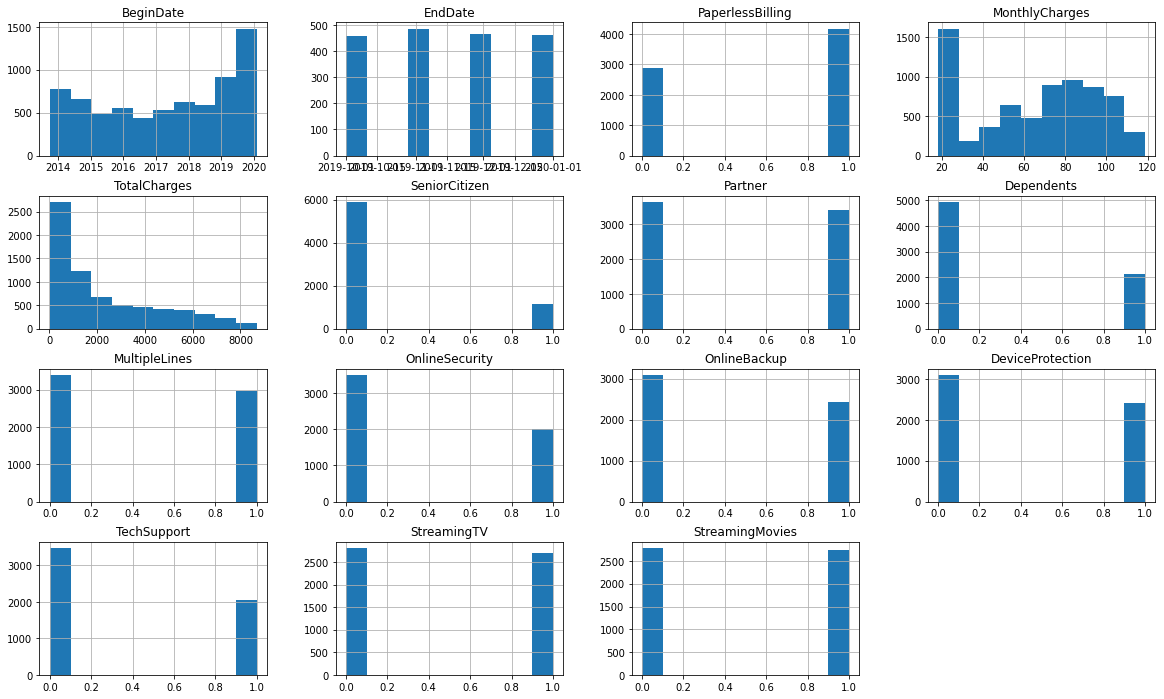

In [24]:
df.hist(figsize=(20, 12));

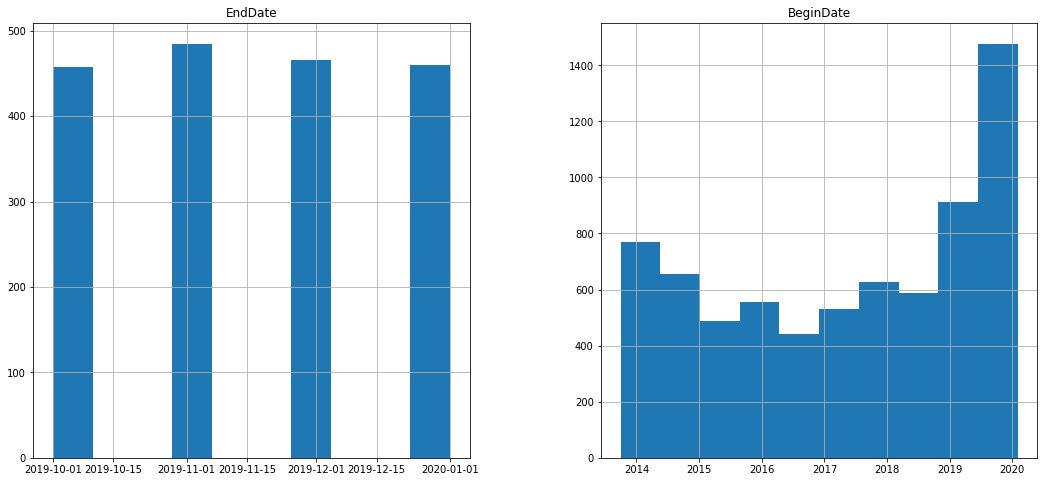

In [25]:
df[['EndDate', 'BeginDate']].hist(figsize=(18, 8));

Так же взглянем на распределения данных, которые представлены в виде строк:

In [26]:
df['gender'].value_counts()

Male      3555
Female    3488
Name: gender, dtype: int64

In [27]:
df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

In [28]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

В полученных распределениях не видно явных перекосов, а аномальные значения отсутствуют.

Однако, во всех данных у клиентов кончается договор только в первые дни месяца с октября 2019 по январь 2020. Но это скорее не ошибка в данных, а специфика их сборки. Например, если договор расторгается первого числа месяца, а система, которая фиксирует данные разрыва договора начала работать только в октябре 2019 года. Тогда при выгрузке данных в феврале 2020 такое распределение соответствует реальности.

Так же с 2019 года наблюдается тренд на увеличение числа новых клиентов. Скорее всего, приток клиентов больше оттока, что подтверждается замеченным ранее дисбалансов классов.

### Пропуски в данных


Взглянем на пропуски в данных:

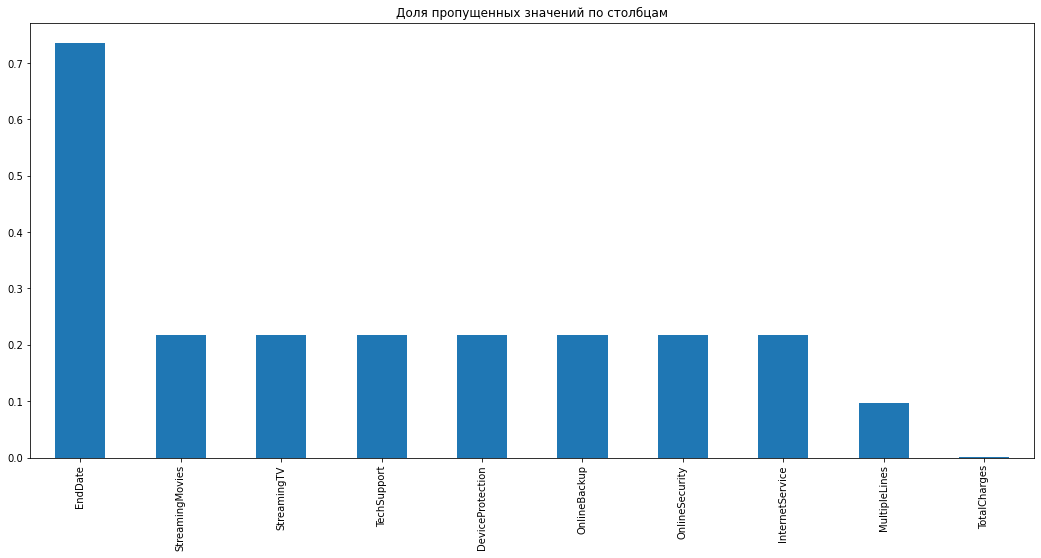

In [29]:
na_count = df.isna().sum().sort_values(ascending=False) / df.shape[0]
na_count = na_count[na_count != 0]

na_count.plot(kind="bar", figsize=(18, 8), title="Доля пропущенных значений по столбцам");

По графику становится видно, что большинство пропусков в столбце EndDate. Это связано с упомянутым ранее дисбалансом классов и все эти пропуски соответствуют одному из целевых классов, а сам столбец скорее всего будет отброшен на этапе предобработки для исключения утечки целевого признака.

В столбце `TotalCharges` меньше процента пропусков, а значит их можно отбросить.

Для устранения пропусков в остальных столбцах требуется их более детальное исследование, что и будет сделано на этапе предобработки. Однако, перед переходом к этому этапу, рассмотрим данные ушедших клиентов и оставшихся по отдельности. Возможно, это позволит установить основные причины их ухода.

Данные оставшихся клиентов:

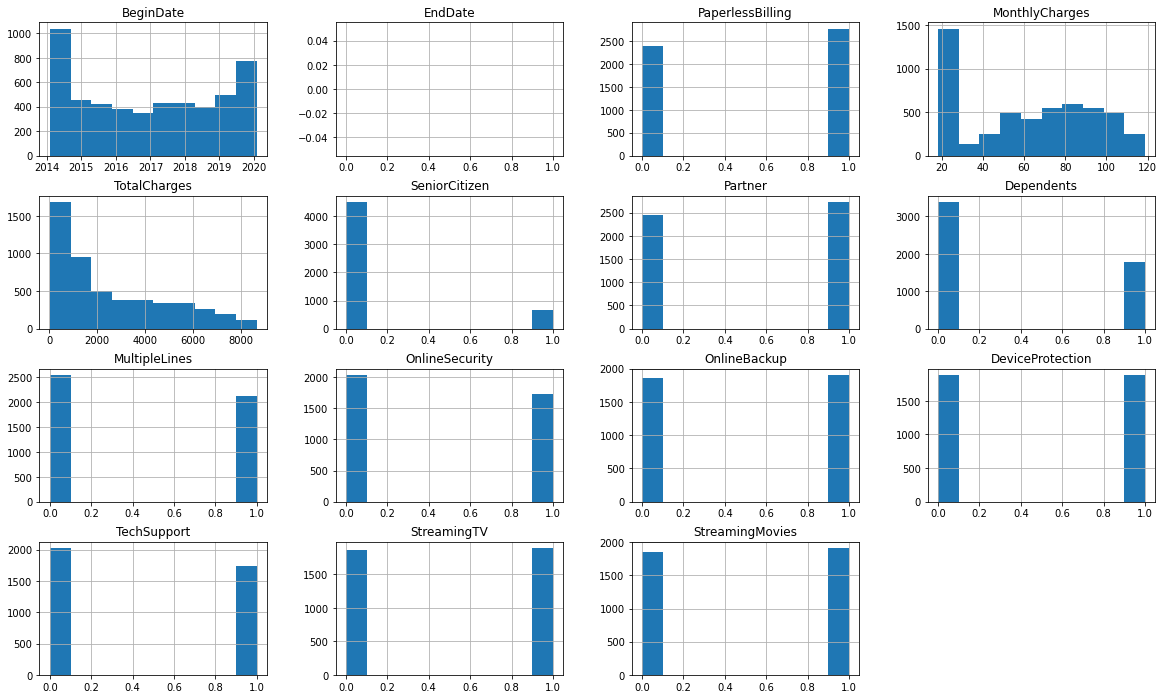

In [30]:
df[df['EndDate'].isna()].hist(figsize=(20, 12));

Данные ушедших клиентов:

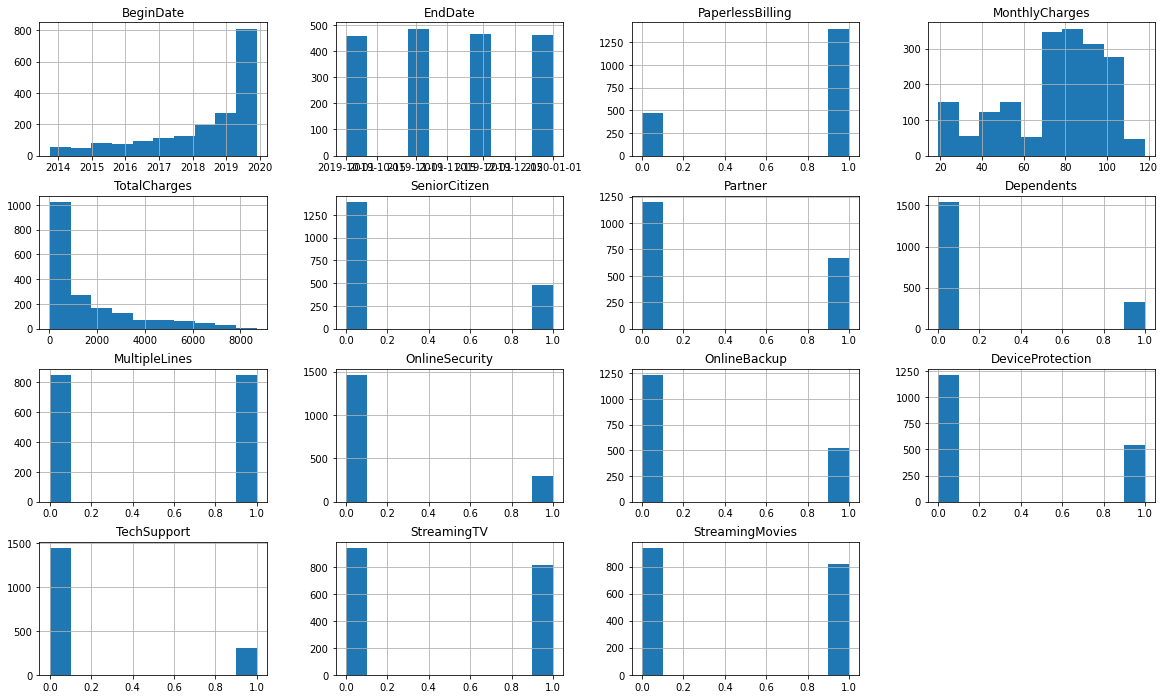

In [31]:
df[df['EndDate'].notna()].hist(figsize=(20, 12));

Как можно заметить, ушедшие клиенты:
- Недавно пользуются сервисом (большинство с 2020 года)
- Имеют более высокие ежемесячные траты
- С меньшей вероятностью состоят в браке
- У них с меньшей вероятностью есть наличие иждивенцев
- С большей вероятностью принадлежат классу пожилых граждан
- Меньше пользуются поддержкой и онлайн сервисами


Из этих выводов можно сделать предположение, что пользователи могут уходить по следующим причинам:
- Меняют оператора по причине высоких трат за месяц
- Принадлежат к мобильной части населения, часто меняющей место проживания и оператора соответственно
- Принадлежат к классу пожилых граждан и отказываются от связи по причине ненадобности/отсутствия необходимости

## Предобработка данных

Ещё раз взглянем на все пропуски в таблице:

In [32]:
df.isna().sum().sort_values(ascending=False)

EndDate             5174
StreamingMovies     1526
StreamingTV         1526
TechSupport         1526
DeviceProtection    1526
OnlineBackup        1526
OnlineSecurity      1526
InternetService     1526
MultipleLines        682
TotalCharges          11
Dependents             0
customerID             0
BeginDate              0
SeniorCitizen          0
gender                 0
MonthlyCharges         0
PaymentMethod          0
PaperlessBilling       0
Type                   0
Partner                0
dtype: int64

In [33]:
df["InternetService"].unique()

array(['DSL', 'Fiber optic', nan], dtype=object)

Случай `EndDate` был разобран ранее и пропуски в данном столбце можно не учитывать.

Однако, сложно не заметить группу столбцов с 1526 пропусками. Все они относятся к использованию интернета пользователем и были получены из датасета `internet.csv`. Причина пропусков в данном случае следующая - при объединении датасетов по id пользователей `contract.csv`/`personal.csv` для 1526 пользователей не нашлось строк в датасете `internet.csv`. Скорее всего, данные об этих пользователях отсутствуют из-за того, что у них не был подключен интернет и сохранение записей о них привело бы к избыточности. Это подтверждает тот факт, что у столбца `InternetService` нет значения об отсутствии интернета, а только о его виде подключения.

Поэтому для столбца `InternetService` пропуски можно заполнить отдельным значением, характеризующим отсутствие инетрнета. А для остальных столбцов с 1526 подойдет заполнение нулями, т.к. они отражают наличие каких-то параметров подключения и принимают значения 0/1.

In [34]:
df["InternetService"] = df["InternetService"].fillna("N/A")
na_cols = df_internet.columns[2:]
df[na_cols] = df[na_cols].fillna(0)

Для столбца `MultipleLines` природа пропусков аналогична столбцам из `internet.csv`, только в данном случае пропуски появились при объединении с `phone.csv`. Поэтому их так же можно заполнить нулями.

In [35]:
df["MultipleLines"] = df["MultipleLines"].fillna(0)

Пропуски `TotalCharges` можно отбросить из-за их малого количества:

In [36]:
df.shape

(7043, 20)

In [37]:
df = df.dropna(subset=["TotalCharges"])

In [38]:
df.shape

(7032, 20)

In [39]:
df.isna().sum().sort_values(ascending=False).head()

EndDate        5163
customerID        0
Dependents        0
StreamingTV       0
TechSupport       0
dtype: int64

Учитывая, что единственный столбец с пропусками будет отброшен далее, можно утверждать, что данные очищенны от пропусков.

Следующим шагом будет формирование синтетических признаков для обучения модели и удаление лишних признаков(например тех, которые имеют высокую мультиколлинеарность с другими признаками).

### Feature selection и Feature engineering

Начнем с формирования целевого признака о том, ушел ли клиент (расторгнул контракт):

In [40]:
df["HasLeft"] = np.where(df["EndDate"].isna(), 0, 1)

In [41]:
df[["EndDate", "HasLeft"]]

,EndDate,HasLeft
0,NaT,0
1,NaT,0
2,2019-12-01,1
3,NaT,0
4,2019-11-01,1
...,...,...
7038,NaT,0
7039,NaT,0
7040,NaT,0
7041,2019-11-01,1


Во время исследования данных было замечено, что важным для предсказания может быть количество дней с момента заключения договора:

In [42]:
df["DaysUsing"] = (DATA_EXTRACT_TIMESTAMP - df['BeginDate']).dt.days

In [43]:
df[["BeginDate", "DaysUsing"]].head()

,BeginDate,DaysUsing
0,2020-01-01,31
1,2017-04-01,1036
2,2019-10-01,123
3,2016-05-01,1371
4,2019-09-01,153


Так же присвоим каждому клиенту категорию трат за месяц. Диапазоны категорий возьмем по процентилям `MonthlyCharges`

In [44]:
df["MonthlyCharges"].describe()

count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
25%        35.587500
50%        70.350000
75%        89.862500
max       118.750000
Name: MonthlyCharges, dtype: float64

In [45]:
conditions = [
    df["MonthlyCharges"] < 35,
    df["MonthlyCharges"].between(35, 70),
    df["MonthlyCharges"] > 70
]

df["MonthlyPaymentCategory"] = np.select(
    conditions,
    [0, 1, 2]
)

In [46]:
df[["MonthlyCharges", "MonthlyPaymentCategory"]]

,MonthlyCharges,MonthlyPaymentCategory
0,29.85,0
1,56.95,1
2,53.85,1
3,42.30,1
4,70.70,2
...,...,...
7038,84.80,2
7039,103.20,2
7040,29.60,0
7041,74.40,2


На этом мы закончим создание синтетических признаков и можем перейти к отбору.

Перед исследованием их коллинеарности удалим признаки с датами для избежания утечки в целевой признак. Так же отбросим признак `customerID` из-за малой ценности для предсказаний.

In [47]:
df = df.drop(["customerID", "BeginDate", "EndDate"], axis=1)

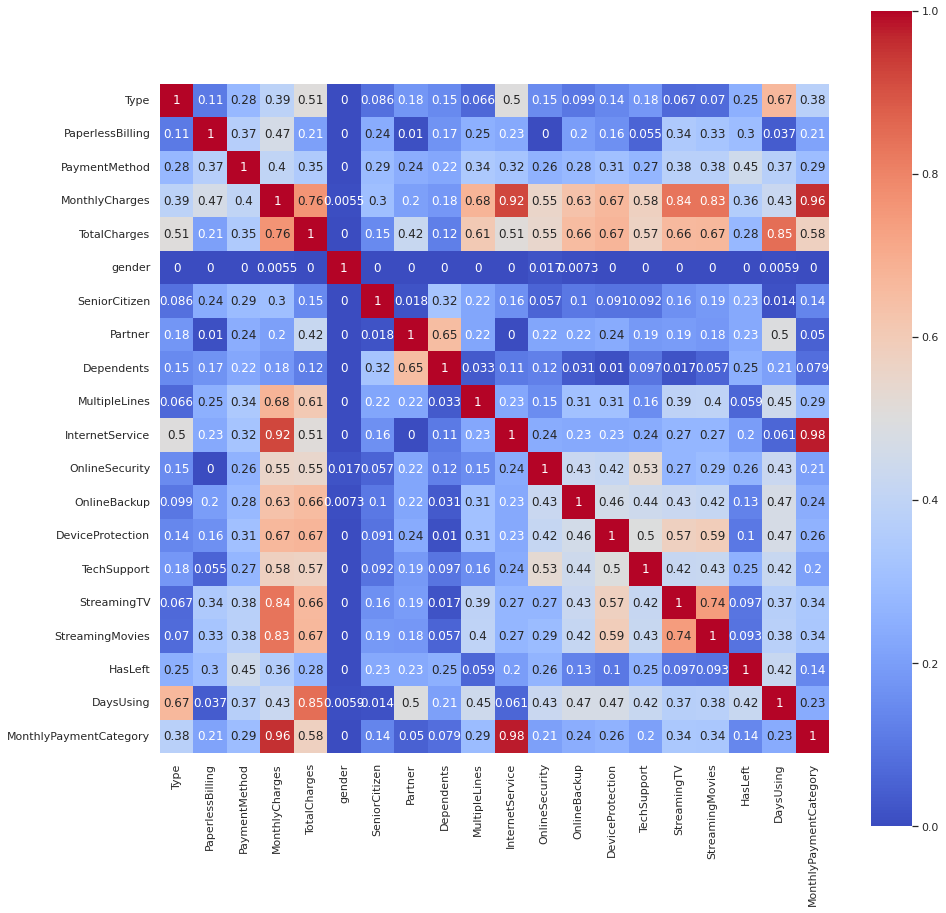

In [48]:
sns.set(rc={'figure.figsize':(15, 15)})
phik_interval_cols = ['MonthlyCharges', 'TotalCharges', 'DaysUsing']

sns.heatmap(df.phik_matrix(interval_cols=phik_interval_cols),
            annot=True, vmin=0, vmax=1, cmap= 'coolwarm', square=True);

Из матрицы видно, что никакой из признаков не коррелирует с целевым. Однако, присутствует некая мультиколлинеарность между признаками. Высокой корреляцией будем считать корреляцию больше 0.90.

Больше всего мультиколлинеарность заметна для `TotalCharges` и `MonthlyCharges`. Поэтому признак `MonthlyCharges` придётся отбросить, но информация из него частично сохранена в синтетическом признаке `MonthlyPaymentCategory`.

При этом `MonthlyPaymentCategory` имеет высокую корреляцию с признаком `InternetService`. Что логично, ведь при подключенном интернета ежемесячная плата будет существенно выше. Признак `InternetService` отображает вид интернет подключения клиента и общее его наличие. Такая информация отражена в других признаках, поэтому его можно отбросить.

Удалим признаки и построим матрицу заново:

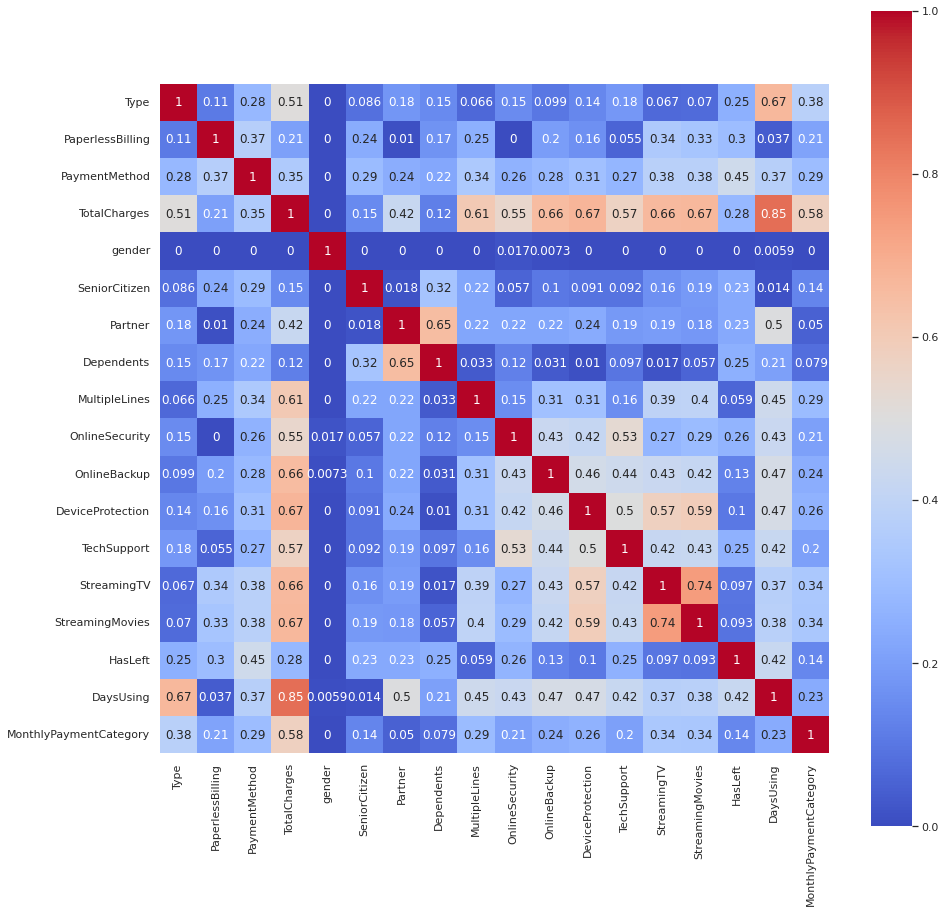

In [49]:
df = df.drop(["MonthlyCharges", "InternetService"], axis=1)

sns.heatmap(df.phik_matrix(interval_cols=phik_interval_cols),
            annot=True, vmin=0, vmax=1, cmap= 'coolwarm', square=True);

У признаков теперь отсутствует мультиколлинеарность, и данные готовы к разбиению на выборки для модели.


### Формирование выборок для тестирования и обучения моделей


Перед началом разбиения данных стоит взглянуть на количество объектов каждого класса в данных:

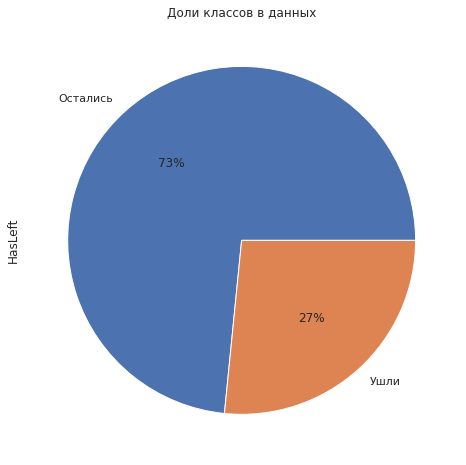

In [50]:
df["HasLeft"].value_counts().plot(kind="pie", title="Доли классов в данных", labels=["Остались", "Ушли"], autopct='%.0f%%', figsize=(8, 8));

Как было замечено ранее, в данных присутствует дисбаланс классов. Однако, метрика ROC-AUC, которая является основной метрикой этого проекта, устойчива к дисбалансу классов, а значит у нас нет необходимость менять количество классов с помощью методик апсемплинга и даунсемплинга.

Разобьем данные на выборки:

In [51]:
features = df.drop(['HasLeft'], axis=1)
target = df['HasLeft']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=TEST_SIZE,
    random_state=RANDOM_STATE, stratify=target
)

In [52]:
X_train.shape

(5274, 17)

In [53]:
X_test.shape

(1758, 17)

Так же очистим память от ненужных датасетов:

In [54]:
del df_internet
del df_contract
del df_phone
del df_personal
del df

## Подбор модели

В рамках данной работы будем подбирать модель среди следующих алгоритмов машинного обучения:
- Случайный лес
- Градиентный бустинг Catboost
- Классификация методом k-ближайших соседей

Перебор гиперпараметров будем производить с помощью RandomizedSearchCV, а с помощью Pipeline будем производить необходимые операции по кодированию и масштабированию данных внутри кросс-валидации.

Кодирование необходимо для правильного представиления категориальных данных, а масштабирование приводит все численные данные к одному диапазону, что критично важно для работы таких алгоритмов как метод k-ближайших соседей, которые учитывают расстояния между измерениями.

Но сначала выделим категориальные и численные столбцы данных:

In [55]:
numerical_cols = ["TotalCharges", "DaysUsing"]
categorical_cols = X_train.drop(numerical_cols, axis=1).columns.tolist()

result_table = pd.DataFrame(columns=["model", "AUC-ROC"])

### Случайный лес

In [56]:
%%time

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),  categorical_cols),
    (StandardScaler(), numerical_cols),
)

pipeline = Pipeline([
    ('transformer', preprocessor),
    ('model', RandomForestClassifier(random_state=RANDOM_STATE))
])

params = {
    'model__n_estimators': range(50, 251, 50),
    'model__max_depth': range(2, 15),
    'model__min_samples_split': range(2, 10),
    'model__min_samples_leaf': range(2, 6)
}

gs = RandomizedSearchCV(
    pipeline,
    cv=StratifiedKFold(),
    param_distributions=params,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gs.fit(X_train, y_train)

best_params = pd.DataFrame(gs.cv_results_).loc[gs.best_index_, 'params']
print(f"Лучшее ROC-AUC : {gs.best_score_:.5f}")
print(f"Параметры лучшей модели:")
print(best_params)

result_table = result_table.append([{"model" : gs.best_estimator_[-1], "AUC-ROC" : gs.best_score_}])
forest_model = gs.best_estimator_

Лучшее ROC-AUC : 0.86610
Параметры лучшей модели:
{'model__n_estimators': 200, 'model__min_samples_split': 7, 'model__min_samples_leaf': 3, 'model__max_depth': 11}
CPU times: user 728 ms, sys: 24.2 ms, total: 752 ms
Wall time: 3.52 s


Модель случайного леса показала значение ROC-AUC немного больше необходимого

### Градиентный бустинг Catboost

In [57]:
%%time

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),  categorical_cols),
    (StandardScaler(), numerical_cols),
)

pipeline = Pipeline([
    ('transformer', preprocessor),
    ('model', CatBoostClassifier(loss_function='Logloss', eval_metric='AUC', random_seed=RANDOM_STATE, logging_level='Silent'))
])

params = {
    'model__depth': range(4, 10),
    'model__learning_rate': np.arange(0.05, 0.2, 0.05),
    'model__iterations': range(10, 101, 10)
}

gs = RandomizedSearchCV(
    pipeline,
    cv=StratifiedKFold(),
    param_distributions=params,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gs.fit(X_train, y_train)

best_params = pd.DataFrame(gs.cv_results_).loc[gs.best_index_, 'params']
print(f"Лучшее ROC-AUC : {gs.best_score_:.5f}")
print(f"Параметры лучшей модели:")
print(best_params)

result_table = result_table.append([{"model" : gs.best_estimator_[-1], "AUC-ROC" : gs.best_score_}])
gradient_model = gs.best_estimator_

Лучшее ROC-AUC : 0.89928
Параметры лучшей модели:
{'model__learning_rate': 0.15000000000000002, 'model__iterations': 60, 'model__depth': 6}
CPU times: user 1.24 s, sys: 237 ms, total: 1.48 s
Wall time: 13.2 s


Модель градиентного бустинга обучалась дольше, но при этом показала существенный рост в значении ROC-AUC

### K-ближайших соседей

In [58]:
%%time

preprocessor = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'),  categorical_cols),
    (StandardScaler(), numerical_cols),
)

pipeline = Pipeline([
    ('transformer', preprocessor),
    ('model', KNeighborsClassifier())
])

params = {
    'model__n_neighbors': range(3, 50, 2),
    'model__weights': ["uniform", "distance"],
    'model__metric': ["euclidean", "manhattan", "cosine"]
}

gs = RandomizedSearchCV(
    pipeline,
    cv=StratifiedKFold(),
    param_distributions=params,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=RANDOM_STATE
)

gs.fit(X_train, y_train)

best_params = pd.DataFrame(gs.cv_results_).loc[gs.best_index_, 'params']
print(f"Лучшее ROC-AUC : {gs.best_score_:.5f}")
print(f"Параметры лучшей модели:")
print(best_params)

result_table = result_table.append([{"model" : gs.best_estimator_[-1], "AUC-ROC" : gs.best_score_}])
knn_model = gs.best_estimator_

Лучшее ROC-AUC : 0.83170
Параметры лучшей модели:
{'model__weights': 'uniform', 'model__n_neighbors': 35, 'model__metric': 'euclidean'}
CPU times: user 270 ms, sys: 20.9 ms, total: 291 ms
Wall time: 1.16 s


Модель классификатора KNN показала самое низкое значение метрики, не превышающей минимальный порог.

Взглянем на результаты обучения моделей:

In [59]:
result_table.sort_values(by="AUC-ROC", ascending=False)

,model,AUC-ROC
0,<catboost.core.CatBoostClassifier object at 0x...,0.899275
0,"(DecisionTreeClassifier(max_depth=11, max_feat...",0.866096
0,"KNeighborsClassifier(metric='euclidean', n_nei...",0.831698


В итоге лучшие результаты показала модель градиентного бустинга, она и будет протестирована на следующем этапе работы.

## Тестирование и анализ финальной модели

Для финального тестирования возьмем лучшую модель и вычислим её ROC-AUC и accuracy на тестовой выборке:

In [60]:
y_probas = gradient_model.predict_proba(X_test)[:, 1]
y_predictions = gradient_model.predict(X_test)

final_roc_auc = roc_auc_score(y_test, y_probas)
final_accuracy = accuracy_score(y_test, y_predictions)

print(f"ROC-AUC на тестовой выборке : {final_roc_auc:.5f}")
print(f"Accuracy на тестовой выборке : {final_accuracy:.5f}")

ROC-AUC на тестовой выборке : 0.89886
Accuracy на тестовой выборке : 0.86234


На тестовой выборке значение ROC-AUC стало еще выше. Скорее всего это связано с использованием полной обучающей выборки. Accuracy так же имеет достаточно высокое значение. Все это говорит о корректной работе модели и высоком качестве предсказаний.

В связи с этим мы можем проанализировать наиболее важные для модели признаки и лучше понять проблему оттока клиентов.

In [61]:
feature_importance = pd.Series(gradient_model._final_estimator.feature_importances_, index=gradient_model[:-1].get_feature_names_out()).sort_values(ascending=False)

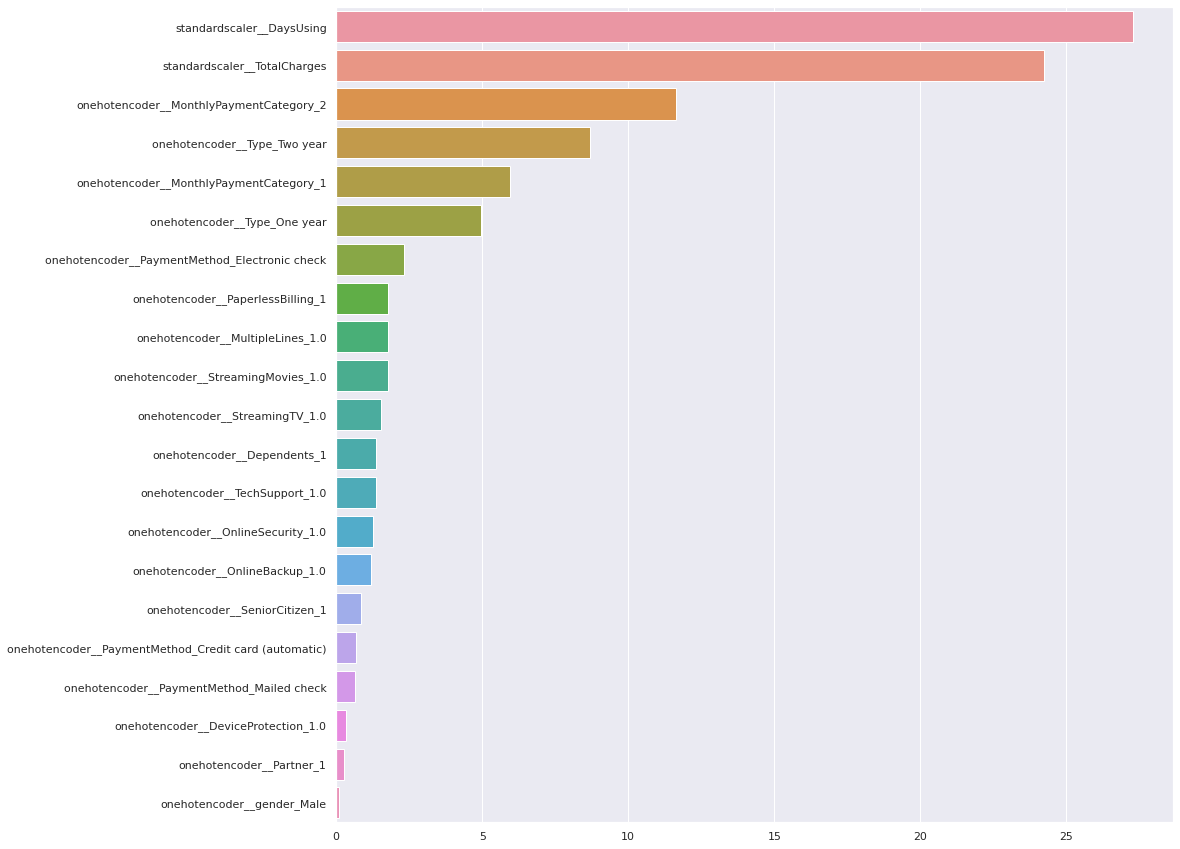

In [62]:
sns.barplot(
    x=feature_importance,
    y=feature_importance.index,
    orient="h"
);

Таким образом, для градиентного бустинга catboost при классификации пользователей наибольшую важность представляют общие траты клиента, и как давно он заключил договор с оператором.

Следующими по значимости идут ежемесячные траты и наличие оплаты сразу на два года вперёд. Оплата на год вперёд тоже влияет на предсказание модели, но не так значительно. Это логично, ведь мало кто оплачивает услуги сервиса на два года вперёд если планирует перестать им пользоваться. Возможно, для удержания уходящего клиента стоит предложить снижение цены на покупку услуг сразу на несколько лет.

Анализ важности признаков подтвердил уже известные правила о том, что чем больше клиент пользуется услугами, тем меньше его вероятность уйти. А так же то, что лояльность клиента напрямую связана с его тратами на услуги.

Однако может быть интересно то, что стриминговое телевиденье и тех. поддержка больше остальных услуг влияют на предсказание. В то время как защита устройств влияет меньше всего. Эта информация может пригодиться при составлении промокодов и специальных условий уходящим клиентам.

Проанализируем модель дальше, построив ROC кривую и матрицу ошибок:

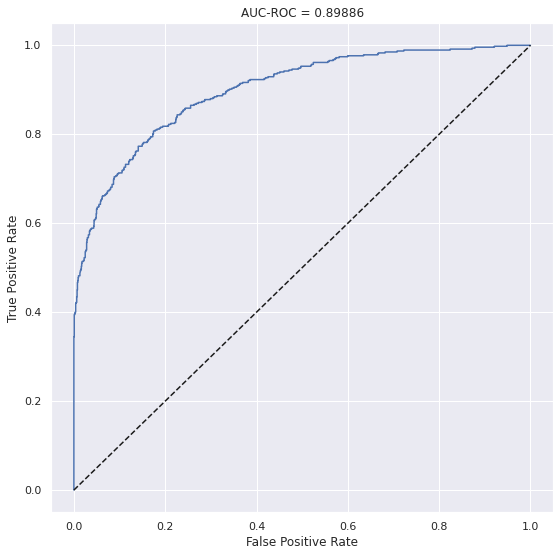

In [63]:
sns.set(rc={'figure.figsize':(9, 9)})

fpr, tpr, _ = roc_curve(y_test,  y_probas)

plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.title(f"AUC-ROC = {final_roc_auc:.5f}")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

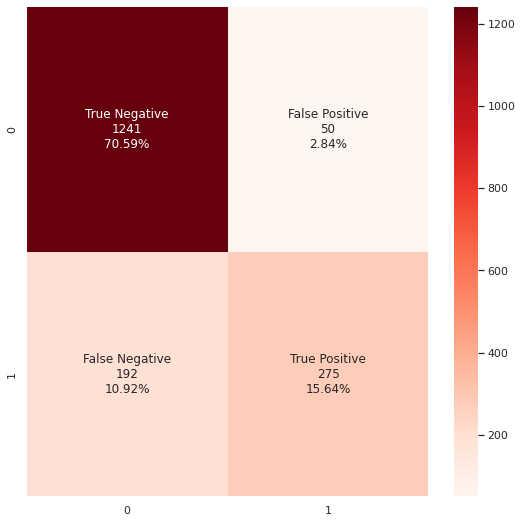

In [64]:
cf_matrix = confusion_matrix(y_test, y_predictions)

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Reds");

In [65]:
recall = recall_score(y_test, y_predictions)
precision = precision_score(y_test, y_predictions)

print(f"Recall = {recall:.5f}\nPrecision = {precision:.5f}")

Recall = 0.58887
Precision = 0.84615


Как можно заметить, ROC кривая отображает высокое качество предсказаний модели. На ней с ростом чувствительности почти не увеличивается вероятность ложного срабатывания.

Метрика Recall показала достаточно низкие значения. Связано это с дисбалансом классов и тем, что негативных объектов в данных значительно больше. Можно увеличить эту метрику путем изменения порога, но при этом нужно принять во внимание бизнес-задачу проекта.

Метрика Recall отвечает за полноту классификации, а Precision за её точность. Поэтому если удержание клиента производится без значительных затрат (промокоды, единоразовые акции), лучше максимизировать метрику Recall, т.к. это уменьшит шанс упустить уходящего клиента. Если же присутствуют более существенные затраты (бесплатные услуги на долгий промежуток времени, оборудование для этих услуг), то лучше выбрать метрику Precision, чтобы средства не были потрачены на клиентов, которые не планировали уходить от оператора.


## Финальный вывод

В рамках данной работы были успешно загружены и исследованы данные о клиентах оператора связи. Во время исследования были найдены отличия ушедших пользователей от текущих. Важность некоторых из этих отличий в дальнейшем подтвердилась при исследовании финальной модели.

Во время предобработки данных были исследованы пропуски и аномальные значения. Аномальных значений в данных обнаружено не было, а большинство пропусков были связаны с отсутствием данных о клиентах при объединении таблиц. Пропуски были заполнены константным значением исходя из того, что если клиента не было в таблице, у него и не было описываемой в данных услуги.

Для обучения модели было создано несколько синтетических признаков, а так же все признаки были исследованы на предмет мультиколлинеарности и корреляции с целевым признаком. Синтетические признаки состояли из кол-ва дней с начала договора клиента и категории ежемесячных трат клиента(низкие, средние, высокие). Последний показал достаточно высокое влияние на предсказание финальной модели. Лишние признаки были отброшены для корректного обучения модели. Был обнаружен значительный дисбаланс классов в данных, который не влияет на целевую метрику ROC-AUC. Однако, он был учтён при формировании выборок обучения и тестирования модели. Там была использована стратификация для сохранения первоначального баланса целевого класса.

С помощью полученных данных были обучены следующие модели машинного обучения:
- Случайный лес
- Градиентный бустинг Catboost
- Классификация методом k-ближайших соседей

Через RandomizedSearchCV производился перебор гиперпараметров, а с помощью Pipeline происходило масштабирование и кодирование данных внутри кросс-валидации. Наилучшее значения ROC-AUC(**0.89708**) на обучающей выборке показал градиентный бустинг с коэффициентом скорости обучения **0.15**, **60** итерациями и глубиной модели равной **6**. На тестовой выборке значение повысилось до **0.89928**, что превышает требуемый порог. Дополнительная метрика Accuracy так же имеет достаточно высокое значение **0.86234** на тестовой выборке. Все это говорит о корректной работе модели и высоком качестве предсказаний.

На основе финальной модели были рассмотрены важные для предсказания модели признаки. Было установлено, что число общих трат и срок договора являются самыми важными факторами при предсказании ухода клиента. Так же была построена ROC кривая и проанализированы метрики recall и precision.

Все пункты первоначального плана были выполнены успешно. Так же была проведена дополнительная работа, не включенная в первоначальный план(проверка векторов на мультиколлинеарность, анализ наиболее важных для модели признаков). Во время работы возникли трудности, связанные с переводом категориальных признаков к численному типу до разбиения данных на выборки. Это обеспечило необходимое построение графиков на этапе анализа, но привело к лишним/повторяющимся операциям на этапе построения матрицы корреляций и обработки данных на этапе `transformer` в `Pipeline`. Оптимальным решением для этой проблемы является создание копии датасета исключительно для исследовательской части работы.